In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax

计算
\begin{align*}
\rho v(a)=\max_cu(c)+v'(a)[w+ra-c]
\end{align*}

显示格式
\begin{align*}
\frac{v_j^{n+1}-v_j^n}{\Delta}+\rho v_j^n=u(c_j^n)+(v_j^n)'[w+ra_j-c_j^n]
\end{align*}
其中
$$
c_j^n=(u')^{-1}[(v_j^n)']
$$

使用迎风格式
$$
v_j'=v_{j,F}'\mathbf{1}_{\{s_{j,F}>0\}}+v_{j,B}'\mathbf{1}_{\{s_{j,B}<0\}}+\bar{v}_j'\mathbf{1}_{\{s_{j,F}<0<s_{j,B}\}}
$$
其中
$$
\bar{v}_{j}^{\prime}=u^{\prime}(w+ra_{j})
$$

In [2]:
s = 2
r = 0.045
rho = 0.05
w = .1

I = 500
amin = -0.02
amax = 1
a = jnp.linspace(amin,amax,I)
da = (amax-amin)/(I-1)

maxit=20000
crit = 10^(-6)

dVf = jnp.zeros((I,))
dVb = jnp.zeros((I,))


#INITIAL GUESS
v0 = (w + r*a)**(1-s)/(1-s)/rho
v = v0

In [3]:
def explict(V):
    maxiteration=10000
    Vchange = V
    for iter in range(maxiteration):
        # if iter%1000 == 0:
        #     print(iter/maxiteration,np.max(np.abs(Vchange)))
        dVf = jnp.concatenate([(V[1:]-V[:-1])/da,jnp.array([0])])
        dVb = jnp.concatenate([jnp.array([(w + r*amin)**(-s)]),(V[1:]-V[:-1])/da])
        cf = dVf**(-1/s)
        sf = w+r*a-cf
        cb = dVb**(-1/s)
        sb = w+r*a-cb
        c0 = w + r*a
        dV0 = c0**(-s)

        If = jnp.where(sf>0, 1, 0)
        Ib = jnp.where(sb<0, 1, 0)
        I0 = (1-If-Ib)     ## sijF<0<sijB
        dV_Upwind = dVf*If + dVb*Ib + dV0*I0
        c = dV_Upwind**(-1/s)
        Vchange = c**(1-s)/(1-s) + dV_Upwind*(w + r*a - c) - rho*V
        # if (jnp.max(jnp.abs(Vchange))<1e-5):
        #     break
        Delta = .9*da/jnp.max(w + r*a)
        V = V+Delta*Vchange
    return V, Vchange, c

In [4]:
%time V, Vchange, c = explict(v)

CPU times: total: 8.36 s
Wall time: 8.68 s


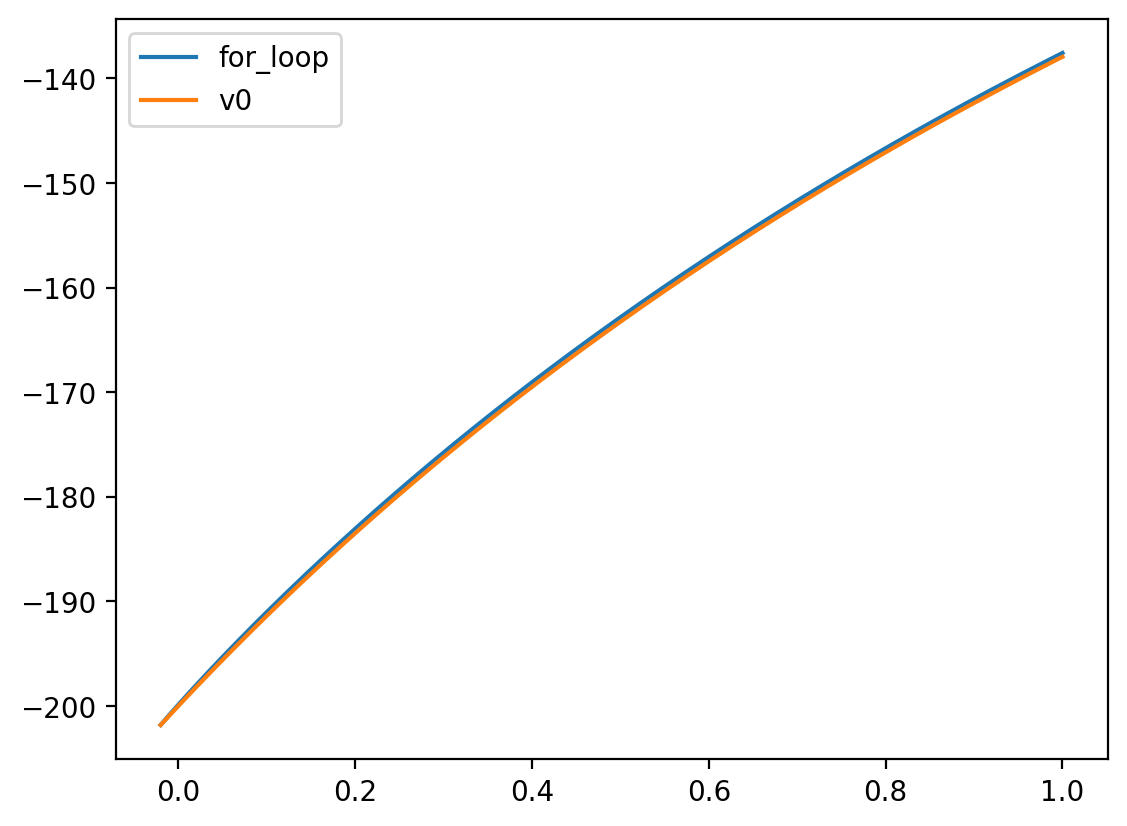

In [5]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.plot(a, V, label='for_loop')
plt.plot(a, v0, label='v0')
plt.legend()

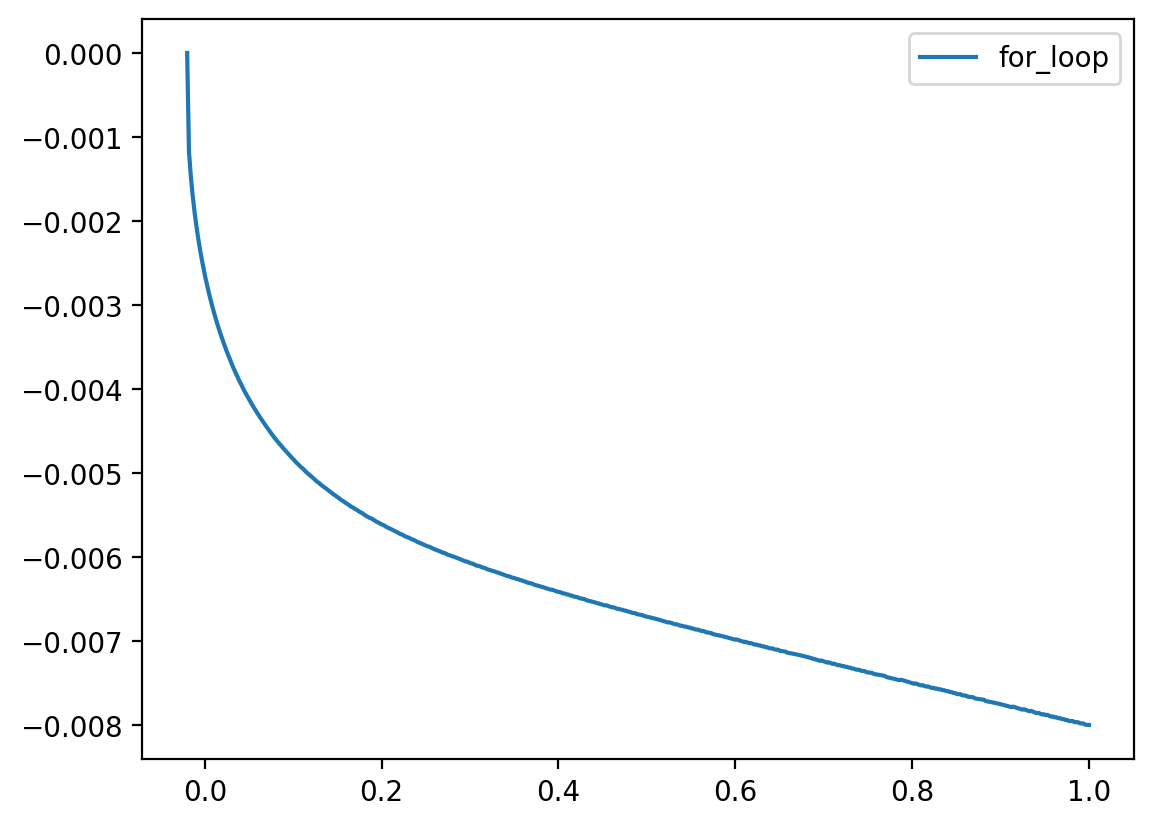

In [6]:
S = w + r*a - c
plt.figure(dpi=200)
plt.plot(a, S, label='for_loop')
plt.legend()

In [7]:
def explict_jax(V):
    maxiteration=10000
    def foriteration(iter,inputs):
        V = inputs
        dVf = jnp.concatenate([(V[1:]-V[:-1])/da,jnp.array([0])])
        dVb = jnp.concatenate([jnp.array([(w + r*amin)**(-s)]),(V[1:]-V[:-1])/da])
        cf = dVf**(-1/s)
        sf = w+r*a-cf
        cb = dVb**(-1/s)
        sb = w+r*a-cb
        c0 = w + r*a
        dV0 = c0**(-s)

        If = jnp.where(sf>0, 1, 0)
        Ib = jnp.where(sb<0, 1, 0)
        I0 = (1-If-Ib)     ## sijF<0<sijB
        dV_Upwind = dVf*If + dVb*Ib + dV0*I0
        c = dV_Upwind**(-1/s)
        Vchange = c**(1-s)/(1-s) + dV_Upwind*(w + r*a - c) - rho*V
        # if (jnp.max(jnp.abs(Vchange))<1e-5):
        #     break
        Delta = .9*da/jnp.max(w + r*a)
        V = V+Delta*Vchange
        return V
    
    V = lax.fori_loop(0, maxiteration, foriteration, V)
    return V
explict_jax = jax.jit(explict_jax)

In [8]:
%time Vc = explict_jax(v)

CPU times: total: 93.8 ms
Wall time: 171 ms


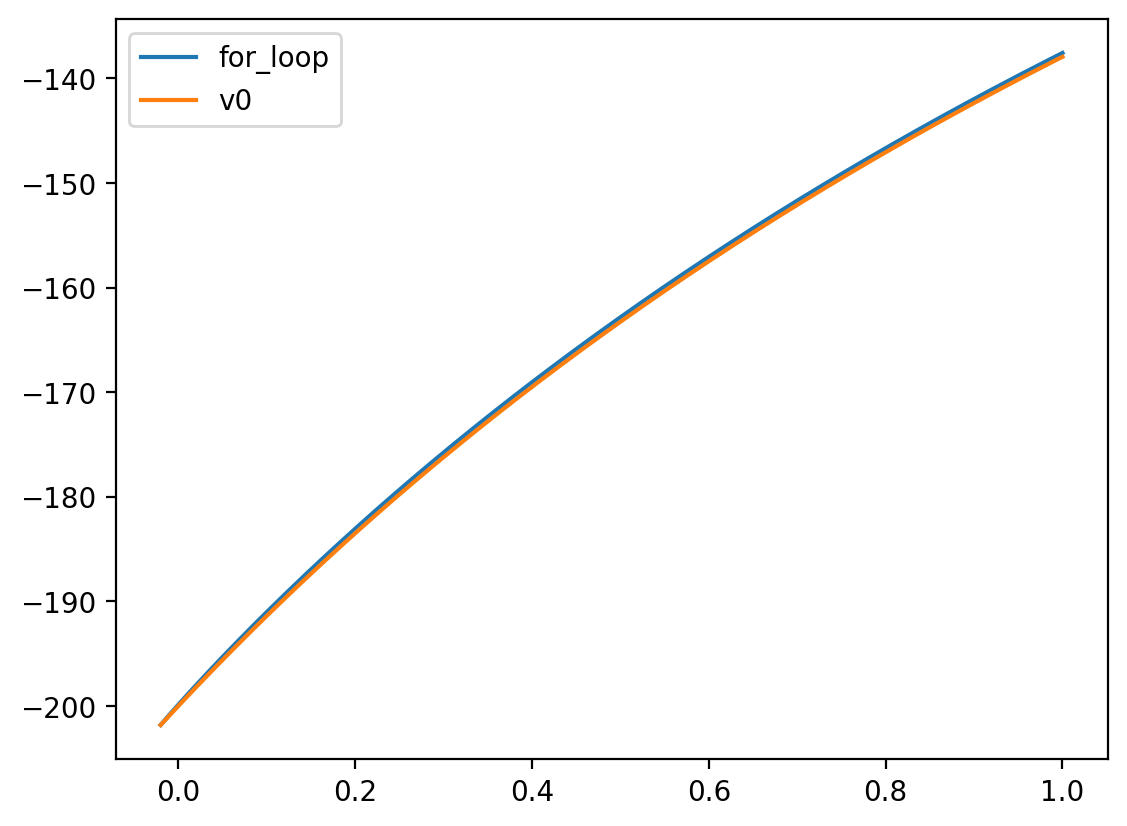

In [9]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.plot(a, V, label='for_loop')
plt.plot(a, v0, label='v0')
plt.legend()